# [`climate4R`](https://github.com/SantanderMetGroup/climate4R) Jupyter Hub. IPCC-AR6 WGI Atlas 
## Meteorology Group, [IFCA](http://ifca.unican.es), CSIC - Univ. of Cantabria)
## Code for regional analysis of CMIP5 indices to produce Atlas FOD figures for the regional synthesis sections (WGI Atlas Section 5).

The [`climate4R`](https://github.com/SantanderMetGroup/climate4R) Jupyter Hub is a service provided by the Institute of Physics of Cantabria ([IFCA](http://ifca.unican.es)) and the Santander Climate Data Service to support the activities of the IPCC-AR6 WGI Atlas. A docker with preinstalled R packages and Jupyter is [available](https://github.com/SantanderMetGroup/climate4R/tree/master/docker) to facilitate reproducibility.   

This notebook includes the code needed to perform regional CMIP5 multi-model analysis of climate indices (including [ETCCDI core indices](http://etccdi.pacificclimate.org/list_27_indices.shtml)) for either the "AR6 WGI reference regions" or the continental-wide areas used in the regional syntheses subsections. A more detailed description of `climate4` and more comprehensive examples are provided in the reference paper (https://doi.org/10.1016/j.envsoft.2018.09.009).  

### INFORMATION: Execution time and memory used

- Time: Model data loading time for each time-slice ranges from 5 to 20 minutes, depending on the Santander Climate Data Service load.

- Size: The R object containing the interpolated daily data for 9 models is 250 Mb aprox.

## 1. Experiment configuration

### 1.1. Selecting the region:  AR6-WGI reference regions 

The **`AR6_WGI_reference_regions`** (individually or aggregated) are one of the alternatives for regional analysis in this notebook. These regions are defined in `visualizeR` (together with  the coastlines). 

In [1]:
library(loadeR)
library(downscaleR)
library(geoprocessoR)
library(visualizeR)
data("AR6_WGI_referenceRegions")
coastLines <- get(load(paste0(find.package("visualizeR"), "/coastline.rda"))) # world coastline
library(sp)
library(RColorBrewer)
library(latticeExtra)

Loading required package: rJava
Loading required package: loadeR.java
Java version 1.7x amd64 by Oracle Corporation detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
loadeR version 1.4.11 (2019-02-04) is loaded
Get the latest stable version (1.4.12) using <devtools::install_github('SantanderMetGroup/loadeR')>
Please use 'citation("loadeR")' to cite this package.
Loading required package: transformeR
transformeR version 1.4.8 (2019-04-16) is loaded
Please see 'citation("transformeR")' to cite this package.
downscaleR version 3.0.5 (2018-12-17) is loaded
Get the latest stable version (3.0.6) using <devtools::install_github(c('SantanderMetGroup/transformeR','SantanderMetGroup/downscaleR'))>
Please use 'citation("downscaleR")' to cite this package.
geoprocessoR version 0.0.0 (2018-08-15) is loaded
Get the latest stable version (0.1.0) using <devtools::install_github('SantanderMetGroup/geoprocessoR')>
Please see 'citation("geoprocessoR")' to cite this package.
visu

The `sp` package allows to work with the regions (defined as spatial polygons).

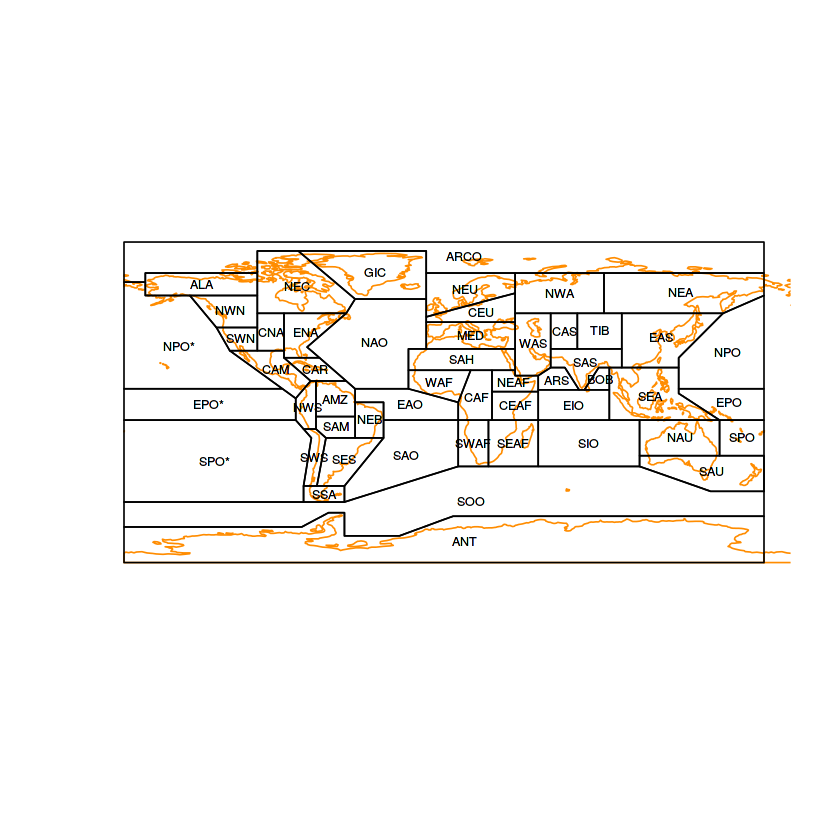

In [2]:
plot(coastLines[[2]], col = "darkorange")
plot(AR6_WGI_referenceRegions, add = TRUE)
text(x = coordinates(AR6_WGI_referenceRegions)[,1],
    y = coordinates(AR6_WGI_referenceRegions)[,2],
    labels = names(AR6_WGI_referenceRegions), cex = 0.6)

In [2]:
names(AR6_WGI_referenceRegions)

Alaska/North-West-Canada           North-East-Canada 
                      "ALA"                       "NEC" 
          Greenland/Iceland    North-West-North-America 
                      "GIC"                       "NWN" 
   South-West-North-America       Central-North-America 
                      "SWN"                       "CNA" 
         East-North-America      Central-America/Mexico 
                      "ENA"                       "CAM" 
                  Caribbean    North-West-South-America 
                      "CAR"                       "NWS" 
      Central-South-America         South-South-America 
                      "SAM"                       "SSA" 
         West-South-America   South-Eeast-South-America 
                      "SWS"                       "SES" 
                     Amazon           North-East-Brazil 
                      "AMZ"                       "NEB" 
               North-Europe              Central-Europe 
                      "NEU"                       "CEU" 
              Mediterranean                      Sahara 
                      "MED"                       "SAH" 
                West-Africa           North-East-Africa 
                      "WAF"                      "NEAF" 
        Central-East-Africa           South-West-Africa 
                     "CEAF"                      "SWAF" 
         South-Eeast-Africa              Central-Africa 
                     "SEAF"                       "CAF" 
            North-East-Asia             North-West-Asia 
                      "NEA"                       "NWA" 
                  West-Asia                Central-Asia 
                      "WAS"                       "CAS" 
            Tibetan-Plateau                   East-Asia 
                      "TIB"                       "EAS" 
                 South-Asia             South-East-Asia 
                      "SAS"                       "SEA" 
            North-Australia South-Australia/New-Zealand 
                      "NAU"                       "SAU" 
                 Antarctica                Arctic-Ocean 
                      "ANT"                      "ARCO" 
             Southern-Ocean              South-Atlantic 
                      "SOO"                       "SAO" 
        Equatorial-Atlantic              North-Atlantic 
                      "EAO"                       "NAO" 
           Equatorial-Indic                 South-Indic 
                      "EIO"                       "SIO" 
                 Arabic-Sea                 Bengal-Gulf 
                      "ARS"                       "BOB" 
              South-Pacific          Equatorial-Pacific 
                      "SPO"                       "EPO" 
              North-Pacific               South-Pacific 
                      "NPO"                      "SPO*" 
         Equatorial-Pacific               North-Pacific 
                     "EPO*"                      "NPO*"

A target region for analysis can be easily defined by aggregating some of the `AR6_WGI_referenceRegions` regions

In [2]:
region <- c("NEU", "CEU", "MED") # Three reference regions covering Europe
lon <- bbox(AR6_WGI_referenceRegions[region])[1,] + c(-3, 4)
lat <- bbox(AR6_WGI_referenceRegions[region])[2,] + c(-6, 2)

Note that, the `lon` and `lat` variables contain the boundaries of the bounding box containing the regions, extracted from an `SpatialPolygons` object (`AR6_WGI_referenceRegions`); note that using `*Spatial` objects allows for further geoprocessing operations. However, the `lon` and `lat` ranges can be also specified manually, as in the example below (specifying the coordinates of the square covering South Asia):

In [3]:
lon <- c(40, 100)
lat <- c(7, 60)

### 1.2. Selecting the region:  AR6-WGI Atlas synthesis regions 

An alternative set of regions has been used in the regional synthesis analysis (Section 5) of the Atlas chapter. These regions are defined in the object **`AR6_WGI_AtlasSynthesisRegions`**, also available in `visualizeR`

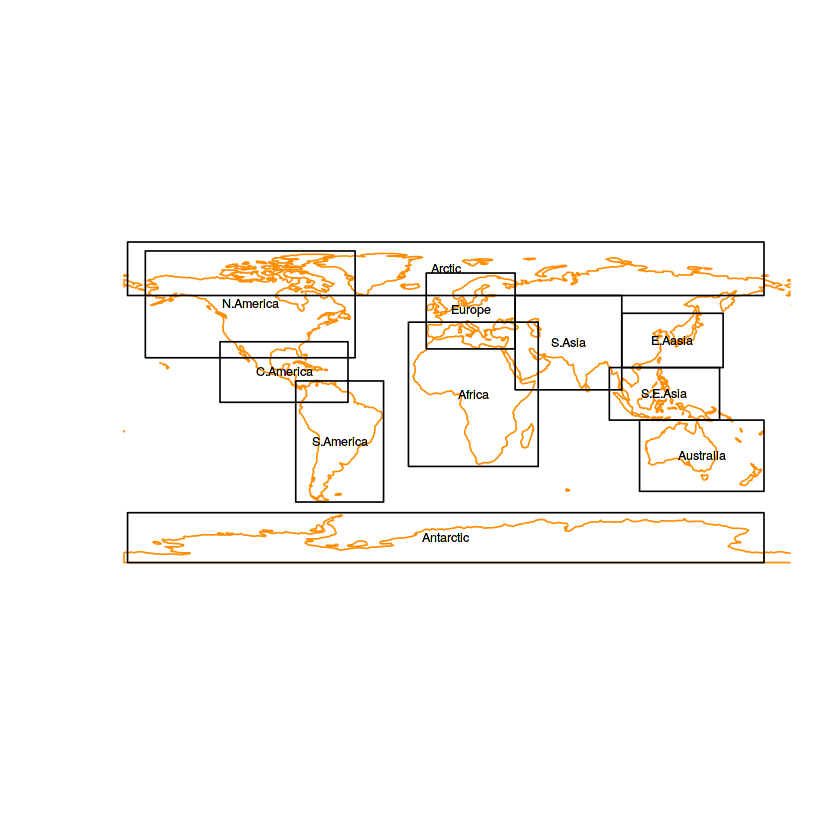

In [4]:
data(AR6_WGI_AtlasSynthesisRegions)
plot(coastLines[[2]], col = "darkorange")
plot(AR6_WGI_AtlasSynthesisRegions, add = TRUE)
text(x = coordinates(AR6_WGI_AtlasSynthesisRegions)[,1],
    y = coordinates(AR6_WGI_AtlasSynthesisRegions)[,2],
    labels = names(AR6_WGI_AtlasSynthesisRegions), cex = 0.6)

In this example we select "Europe" from `AR6_WGI_AtlasSynthesisRegions` as target region:

In [5]:
region <- "Europe"  # <== Change the analysis target region 

lon <- bbox(AR6_WGI_AtlasSynthesisRegions[region])[1,]
lat <- bbox(AR6_WGI_AtlasSynthesisRegions[region])[2,]

### 1.3. Selecting the variable and season

Besides the geographical region of interest, the variable and season are also specified for all subsequent calculations:

In [6]:
var    <- "tasmax"   # <== Alternative options: "tas", "tasmin", "tasmax", "precip"
season <- "Annual"   # <== Alternative options: "DJF", "MAM", "JJA", "SON"

seas <- switch(season,
               "DJF" = c(12, 1, 2),
               "MAM" = 3:5,
               "JJA" = 6:8,
               "SON" = 9:11,
               "Annual" = 1:12)

It is always recommendable to save the data that results from operations performed at different stages of the climate data loading and post-processing chain. Therefore, here we define and create the directories for saving R data objects (`*.rda`) and figures:

### 1.4. Creating output directories for saving data and figures

In [7]:
data_dir <- "data/"  # Directory for saving data
fig_dir <- "figs/"   # Directory for saving figures

dir.create(data_dir, recursive = TRUE)
dir.create(fig_dir, recursive = TRUE)

Warning message in dir.create(data_dir, recursive = TRUE):
“'data' already exists”Warning message in dir.create(fig_dir, recursive = TRUE):
“'figs' already exists”

## 2. Loading Observational Data (EWEMBI Dataset)

`climate4R` can transparently access data from the Santander Climate Data Service via the User Data Gateway (UDG). This data service provides harmonized data for a number of popular datasets in climate studies (such as gridded observations, reanalysis, and climate change projections from CMIP and CORDEX). The function `UDG.datasets` displays the full list of available datasets. These datasets can be loaded from `climate4R` just indicating the dataset name. However, registration (http://www.meteo.unican.es/udg-tap) is required in order to obtain an authorized user and password. All public datasets are available with the role "PUBLIC" which is automatically granted upon request (after accepting the different acknowledgement terms and licences holding on the datasets). The function `loginUDG` sets authorization credentials for the current R session.

In [9]:
loginUDG(username = "YOUR_USER", password = "YOUR_PASSWORD") # UDG server Login

[2019-04-30 19:46:04] Setting credentials...
[2019-04-30 19:46:04] Success!
Go to <http://www.meteo.unican.es/udg-tap/home> for details on your authorized groups and datasets


As observational reference dataset we will use EWEMBI (which is the reference for the ISI-MIP initiative; [more info](https://www.isimip.org/gettingstarted/details/27/)). 

In [10]:
period <- 1985:2004 # One of the GCMs has no data for Dec 2005  
obs<-loadGridData(dataset = "PIK_Obs-EWEMBI",
               var = var,
               lonLim = lon,
               latLim = lat,
               season = seas,
               years = period)

NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-30 19:46:13] Defining harmonization parameters for variable "tasmax"
[2019-04-30 19:46:13] Opening dataset...
[2019-04-30 19:46:16] The dataset was successfuly opened
[2019-04-30 19:46:16] Defining geo-location parameters
[2019-04-30 19:46:16] Defining time selection parameters
[2019-04-30 19:46:16] Retrieving data subset ...
[2019-04-30 19:49:19] Done


The function `interpGrid` performs regridding from a particular `climate4R` grid towards a target spatial grid (e.g. obtained with `getGrid`). Standard bilineal and nearest neighbor interpolation methods are defined building on standard implementations from the `akima` and `fields` packages (`?interpGrid` for more details. NOTE: Conservative gridding will be included in a future version).
In particular, **we consider a 2 degrees regular grid as the common grid for all calculations.**

In [11]:
grid <- getGrid(obs)      # Obtaninig the grid from the reference (0.5 deg)
attr(grid, "resX") <- 2   # Changing the resolution to 2 deg
attr(grid, "resY") <- 2
obs2 <- interpGrid(obs, grid, method="bilinear")  # Regridding 

[2019-04-30 19:49:21] Performing bilinear interpolation... may take a while
[2019-04-30 19:50:16] Done


[2019-04-30 19:51:18] - Computing climatology...
[2019-04-30 19:51:18] - Done.


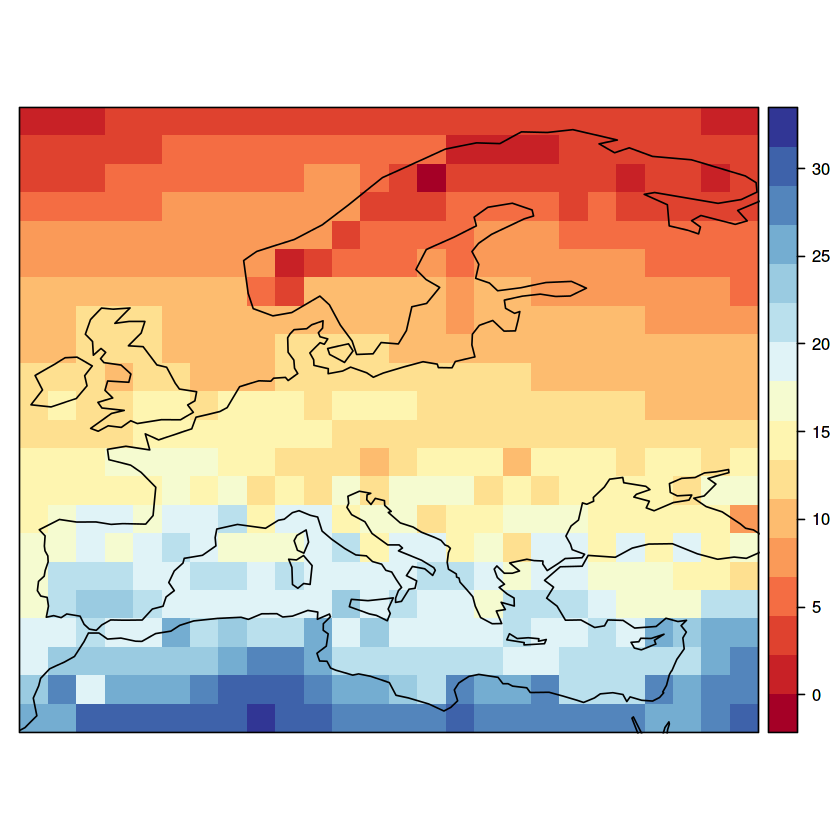

In [12]:
spatialPlot(climatology(obs2), backdrop.theme = "coastline")

The loaded and postprocessed EWEMBI data can be stored locally (in `.rda` format) for quick access in a different session, avoiding to load the data again for additional calculations of indices:

In [ ]:
fileName <- paste0(data_dir, "EWEMBI_", 
       gsub(toString(region), pattern = ", ", replacement = "-"), "_", season, "_", var, "_", 
       gsub(toString(range(period)), pattern = ", ", replacement = "-"),".rda")
fileName
save(obs2, file = fileName)   # 16 MB

In [ ]:
# Uncomment the following line to load the previously stored *.rda object 
#load(fileName)

## 3. Loading Historical Model Data (CMIP5 subset)

Now we load data from the nine historical models data from the CMIP5 subset used the Atlas First Order Draft (FOD; see Atlas Chapter for details). First we load data from the historical scenario for the same `period` used for the observational reference.

In [13]:
source <- "CMIP5" # Options: "CMIP5", "CORDEX-AFR44"
scenario <- "historical"  # Options: "historical", "rcp45", "rcp85"
models <- UDG.datasets(pattern = paste0(source, ".*", scenario))$name
models

[1] "CMIP5_CanESM2_r1i1p1_historical"     
 [2] "CMIP5_CNRM-CM5_r1i1p1_historical"    
 [3] "CMIP5_IPSL-CM5A-MR_r1i1p1_historical"
 [4] "CMIP5_MIROC-ESM_r1i1p1_historical"   
 [5] "CMIP5_GFDL-ESM2M_r1i1p1_historical"  
 [6] "CMIP5_MPI-ESM-MR_r1i1p1_historical"  
 [7] "CMIP5_MPI-ESM-LR_r1i1p1_historical"  
 [8] "CMIP5_HadGEM2-ES_r1i1p1_historical"  
 [9] "CMIP5_EC-EARTH_r12i1p1_historical"   
[10] "CMIP5_NorESM1-M_r1i1p1_historical"

In [14]:
#Removing "CMIP5_MPI-ESM-MR" to avoid model duplicity
models <- models[-6]

In [17]:
hist <- lapply(models, function(x)
  loadGridData(dataset = x,
               var = var,
               lonLim = lon,
               latLim = lat,
               season = seas,
               years = period))

NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-26 14:33:20] Defining harmonization parameters for variable "tasmax"
[2019-04-26 14:33:20] Opening dataset...
[2019-04-26 14:33:33] The dataset was successfuly opened
[2019-04-26 14:33:33] Defining geo-location parameters
[2019-04-26 14:33:33] Defining time selection parameters
[2019-04-26 14:33:33] Retrieving data subset ...
[2019-04-26 14:33:43] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-26 14:33:43] Defining harmonization parameters for variable "tasmax"
[2019-04-26 14:33:43] Opening dataset...
[2019-04-26 14:34:00] The dataset was successfuly opened
[2019-04-26 14:34:00] Defining geo-location parameters
[2019-04-26 14:34:00] Defining time selection parameters
[2019-04-26 14:34:00] Retrieving data subset ...
[2019-04-26 14:34:22] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-26 14:34:22] Defining harmonization parameters for variable "tasmax"
[2019-04-26 14:34:23

In [18]:
# Get temporal intersection of all members:
hist <- intersectGrid(hist, type = "temporal", which.return = 1:length(hist))

In [19]:
# Interpolation to the reference two-degrees grid
hist <- lapply(hist, function(x) interpGrid(x, grid, method="bilinear"))
# Ensemble building (multi-member grid)                
hist <- bindGrid(hist, dimension = "member")

Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”[2019-04-26 14:43:37] Performing bilinear interpolation... may take a while
[2019-04-26 14:44:26] Done
Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”Warning message in interpGrid(x, grid, method = "bilinear"):
“The new latitudes are outside the data extent”[2019-04-26 14:44:26] Performing bilinear interpolation... may take a while
[2019-04-26 14:45:14] Done
Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”Warning message in interpGrid(x, grid, method = "bilinear"):
“The new latitudes are outside the data extent”[2019-04-26 14:45:14] Performing bilinear interpolation... may take a while
[2019-04-26 14:46:03] Done
Warning message in interpGrid(x, grid, method = "bilinear"):
“The new longitudes are outside the data extent”[2019-04-26 14:46:03] Performing biline

Note that the metadata for the members is created by default (`Member_1, Member_2, ...`):

In [20]:
str(hist)

List of 6
 $ Variable           :List of 2
  ..$ varName: chr "tasmax"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi TRUE
  ..- attr(*, "description")= chr "Daily Maximum Near-Surface Air Temperature"
  ..- attr(*, "units")= chr "degC"
  ..- attr(*, "longname")= chr "maximum 2-m air temperature"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
  ..- attr(*, "subset")= chr "time"
  ..- attr(*, "time_subset")= chr "intersectGrid.time"
 $ Data               : num [1:9, 1:7160, 1:22, 1:26] 18.7 NA NA 24.2 NA ...
  ..- attr(*, "dimensions")= chr [1:4] "member" "time" "lat" "lon"
 $ xyCoords           :List of 2
  ..$ x: num [1:26] -9.75 -7.75 -5.75 -3.75 -1.75 0.25 2.25 4.25 6.25 8.25 ...
  ..$ y: num [1:22] 29.8 31.8 33.8 35.8 37.8 ...
  ..- attr(*, "resX")= num 2
  ..- attr(*, "resY")= num 2
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "interpolation")= chr "bilin

We can change the member names in the grid easily using the list of model names (object `models`). 
In this case, we opt to shorten the name using function `gsub`:

In [15]:
modelNames <- gsub(models, pattern = "_r1.*", replacement = "")
modelNames

[1] "CMIP5_CanESM2"      "CMIP5_CNRM-CM5"     "CMIP5_IPSL-CM5A-MR"
[4] "CMIP5_MIROC-ESM"    "CMIP5_GFDL-ESM2M"   "CMIP5_MPI-ESM-LR"  
[7] "CMIP5_HadGEM2-ES"   "CMIP5_EC-EARTH"     "CMIP5_NorESM1-M"

The internal plotting function called by `spatialPlot` is not able to interpret "-" in the names, therefore, we use `gsub` again to replace "-" with "." 

In [16]:
modelNames <- gsub(modelNames, pattern = "-", replacement = ".")

Finally, the names are assigned to the grid:

In [23]:
hist$Members <- modelNames

[2019-04-26 14:50:56] - Computing climatology...
[2019-04-26 14:50:57] - Done.


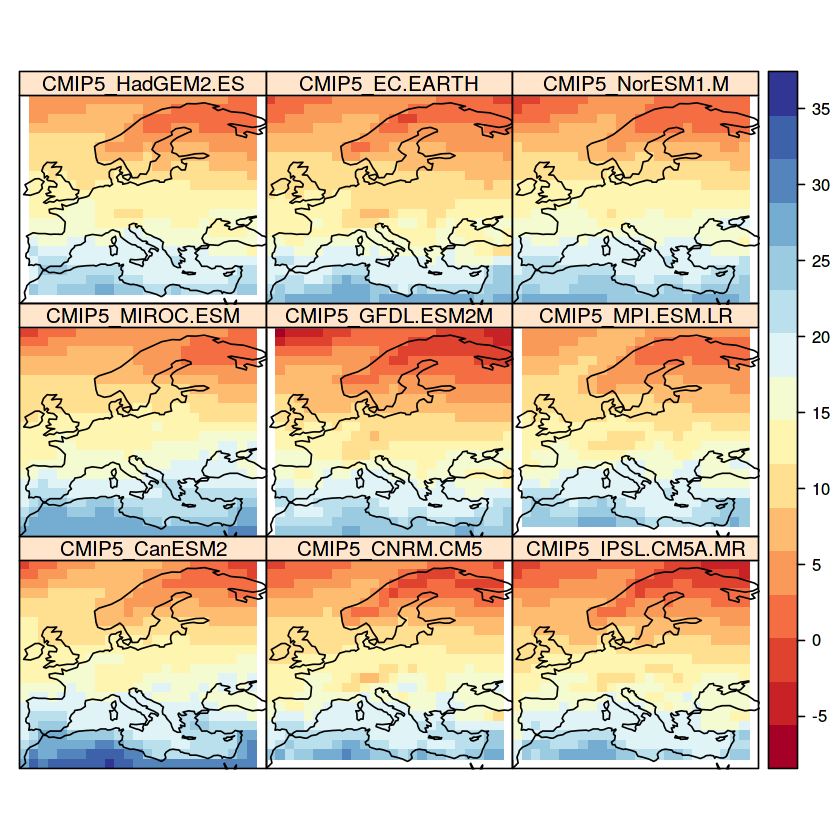

In [24]:
spatialPlot(climatology(hist),backdrop.theme = "coastline")

In [25]:
hist.ens <- aggregateGrid(hist, aggr.mem = list(FUN = "mean", na.rm = TRUE))

[2019-04-26 14:50:58] - Aggregating members...
[2019-04-26 14:51:20] - Done.


[2019-04-26 14:51:20] - Computing climatology...
[2019-04-26 14:51:20] - Done.


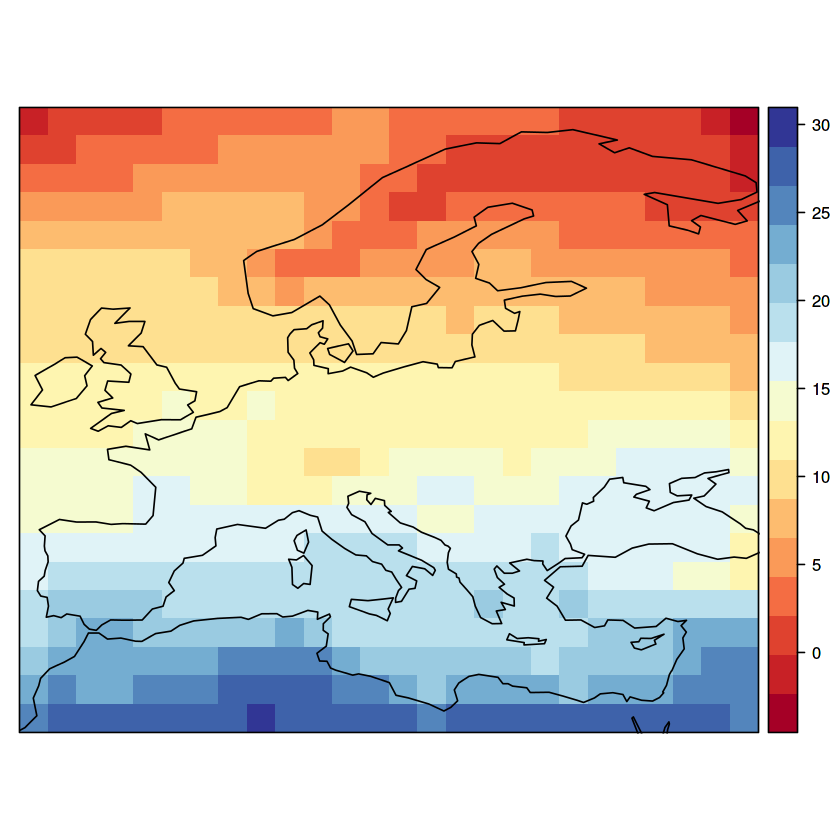

In [26]:
spatialPlot(climatology(hist.ens), backdrop.theme = "coastline")

In [ ]:
fileName <- paste0(data_dir, source, "_", scenario, "_",
                   gsub(toString(region), pattern = ", ", replacement = "-"), "_", 
                   season, "_", var, "_", 
                   gsub(toString(range(period)), pattern = ", ", replacement = "-"),".rda")
fileName

In [ ]:
save(hist, file = fileName)
# Uncomment the following line (and comment the above) to load the *.rda 
#load(fileName)

## 4. Loading Future Projections (RCP8.5 time-slice)

In [19]:
period <- 2061:2080
scenario <- "rcp85" # "rcp45"
models <- UDG.datasets(pattern = paste0(source, ".*", scenario))$name
models <- models[-6]
models

[1] "CMIP5_CanESM2_r1i1p1_rcp85"      "CMIP5_CNRM-CM5_r1i1p1_rcp85"    
[3] "CMIP5_IPSL-CM5A-MR_r1i1p1_rcp85" "CMIP5_MIROC-ESM_r1i1p1_rcp85"   
[5] "CMIP5_GFDL-ESM2M_r1i1p1_rcp85"   "CMIP5_MPI-ESM-LR_r1i1p1_rcp85"  
[7] "CMIP5_HadGEM2-ES_r1i1p1_rcp85"   "CMIP5_EC-EARTH_r12i1p1_rcp85"   
[9] "CMIP5_NorESM1-M_r1i1p1_rcp85"

NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-26 14:52:37] Defining harmonization parameters for variable "tasmax"
[2019-04-26 14:52:37] Opening dataset...
[2019-04-26 14:55:17] The dataset was successfuly opened
[2019-04-26 14:55:17] Defining geo-location parameters
[2019-04-26 14:55:17] Defining time selection parameters
[2019-04-26 14:55:17] Retrieving data subset ...
[2019-04-26 14:55:24] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-26 14:55:24] Defining harmonization parameters for variable "tasmax"
[2019-04-26 14:55:24] Opening dataset...
[2019-04-26 14:55:41] The dataset was successfuly opened
[2019-04-26 14:55:41] Defining geo-location parameters
[2019-04-26 14:55:41] Defining time selection parameters
[2019-04-26 14:55:41] Retrieving data subset ...
[2019-04-26 14:56:02] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-04-26 14:56:02] Defining harmonization parameters for variable "tasmax"
[2019-04-26 14:56:02

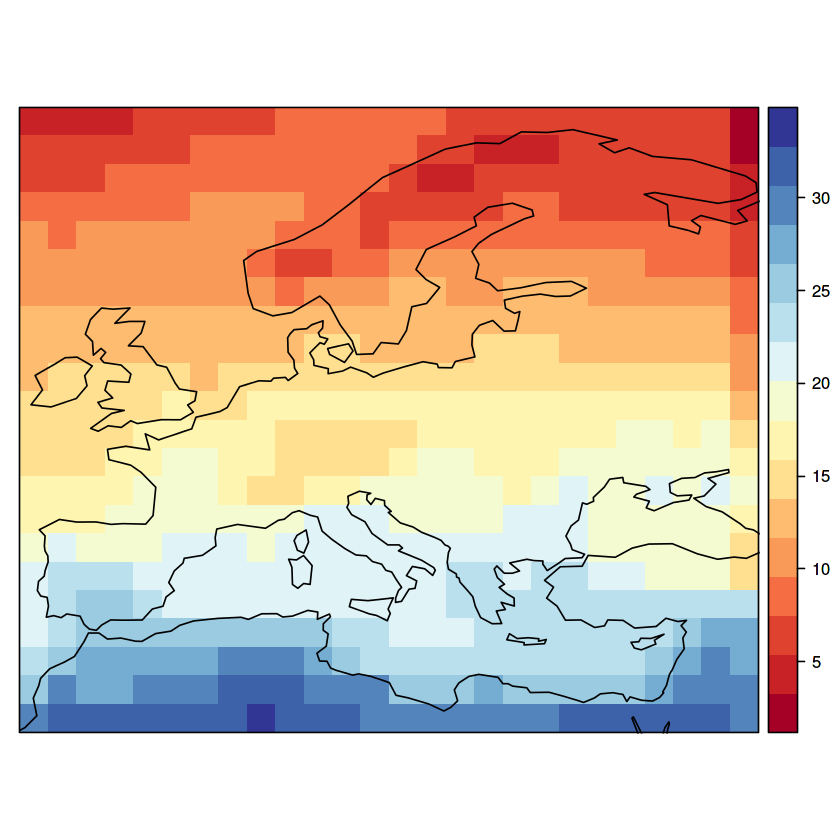

In [29]:
fut <- lapply(models, function(x)
  loadGridData(dataset = x,
               var = var,
               lonLim = lon,
               latLim = lat,
               season = seas,
               years = period))
fut <- intersectGrid(fut, type = "temporal", which.return = 1:length(fut))
fut <- lapply(fut, function(x) interpGrid(x, grid, method="bilinear"))
# Ensemble building (multi-member grid)                
fut <- bindGrid(fut, dimension = "member")
fut$Members <- modelNames
fut.ens <- aggregateGrid(fut, aggr.mem = list(FUN = "mean", na.rm = TRUE))

[2019-04-30 19:53:24] - Aggregating members...
[2019-04-30 19:53:47] - Done.
[2019-04-30 19:53:47] - Computing climatology...
[2019-04-30 19:53:47] - Done.


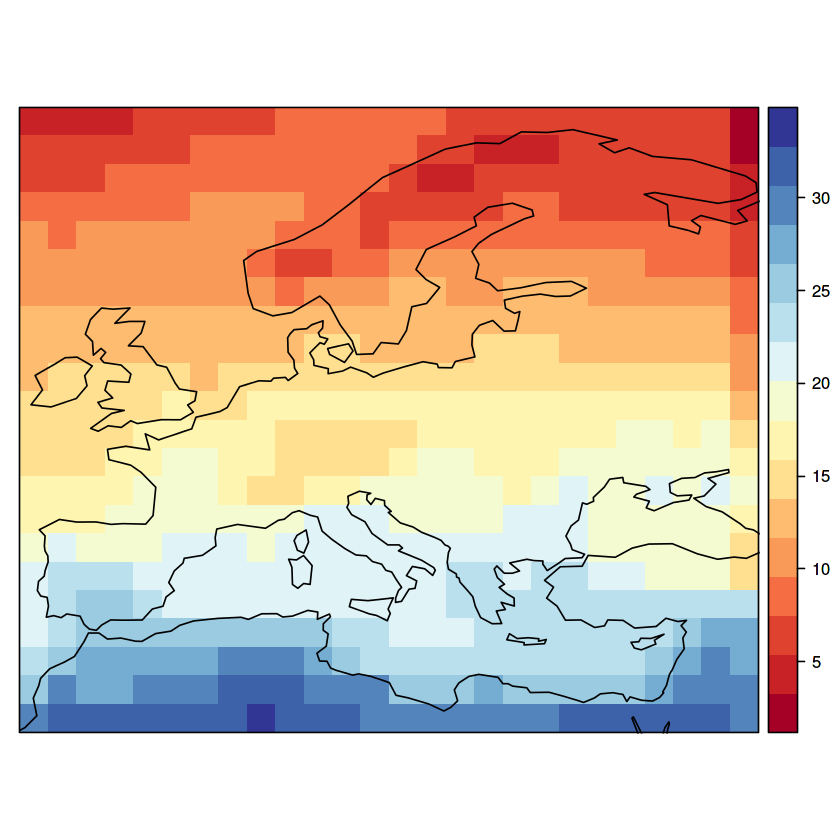

In [24]:
spatialPlot(climatology(fut.ens),backdrop.theme = "coastline")

In [20]:
fileName <- paste0(data_dir, source, "_", scenario, "_",
                   gsub(toString(region), pattern = ", ", replacement = "-"), "_", 
                   season, "_", var, "_", 
                   gsub(toString(range(period)), pattern = ", ", replacement = "-"),".rda")
fileName

[1] "data/CMIP5_rcp85_Europe_Annual_tasmax_2061-2080.rda"

In [21]:
save(fut, file = fileName)
# Uncomment the following line (and comment the above) to load the *.rda 
#load(fileName)

## 5. Calculation of (extreme) Indices

There are two packages to compute indices within the climate4R framework:
* **`climate4R.climdex`** to compute an **'ETCCDI'** index (using the external `climdex` package via a wrapper). Function `climdexShow` displays available indices. Index calculation is performed by function `climdexGrid`.
* **`climate4R.indices`** to compute specific indices used in a variety of projects (incluing IPCC reports). Function `indexShow` displays available indices. Index calculation is performed by function `indexGrid`.

In [22]:
library(climate4R.climdex)
climdexShow()

Loading required package: climdex.pcic
Loading required package: PCICt
climate4R.climdex version 0.2.0 (2018-12-18) is loaded
Get the latest stable version (0.2.1) using <devtools::install_github('SantanderMetGroup/climate4R.climdex')>
Use 'climdexShow()' for an overview of the available ETCCDI indices


code,longname,indexfun,tn,tx,pr,units,description
FD,Number_of_frost_days,climdex.fd,1,0,0,days,Annual_count_of_days_when_TN<0degC
SU,Number_of_summer_days,climdex.su,0,1,0,days,Annual_count_of_days_when_TX>25degC
ID,Number_of_icing_days,climdex.id,0,1,0,days,Annual_count_of_days_when_TX<0degC
TR,Number_of_tropical_nights,climdex.tr,1,0,0,days,Annual_count_of_days_when_TN>20degC
GSL,Growing_season_length,climdex.gsl,1,1,0,days,"Annual(1st Jan to 31st Dec in Northern Hemisphere (NH), 1st July to 30th June in Southern Hemisphere (SH)) count between first span of at least 6 days with daily mean temperature TG>5degC and first span after July 1st (Jan 1st in SH) of 6 days with TG<5degC"
TXx,Monthly_maximum_value_of_daily_maximum_temperature,climdex.txx,0,1,0,NA,NA
TNx,Monthly_maximum_value_of_daily_minimum_temperature,climdex.tnx,1,0,0,NA,NA
TXn,Monthly_minimum_value_of_daily_maximum_temperature,climdex.txn,0,1,0,NA,NA
TNn,Monthly_minimum_value_of_daily_minimum_temperature,climdex.tnn,1,0,0,NA,NA
TN10p,Percentage_of_days_when_TN<10th_percentile,climdex.tn10p,1,0,0,percentage,NA


In [23]:
library(climate4R.indices)
indexShow()

climate4R.indices version 0.0.0 (2019-04-25) is loaded
Get the latest stable version (0.0.1) using <devtools::install_github('SantanderMetGroup/climate4R.indices')>
Use 'indicesShow()' for an overview of the available ETCCDI indices


code,longname,indexfun,tn,tx,tm,pr,units,description
FD,Number_of_frost_days,tn.th,1,0,0,0,days,Count_of_days_when_TN<0degC
TNth,Number_of_cold_days,tn.th,1,0,0,0,days,Count_of_days_when_TN<THdegC
TXth,Number_of_hot_days,tx.th,0,1,0,0,days,Count_of_days_when_TX>THdegC
GDD,Growing_Degree_Days,gdd.th,0,0,1,0,degC,Accumulated_sum_of_degrees_of_and_when_TM>THdegC
CDD,Cooling_Degree_Days,cdd.th,1,1,1,0,days,Count_of_days_being_TH=22degC
HDD,Heating_Degree_Days,hdd.th,1,1,1,0,days,Count_of_days_being_TH=15.5degC
P,Percentile,percentile,0,0,0,0,NA,Climate_value_or_percentile


### 5.1. Days with Tmax above 35º: Index Calculation

In this example we compute a particular index used in the Atlas FOD, the number of dayes with maximum temperature above 35º, with code `TXth` specifigying the threshold parameter `th=35` inside the `index.arg.list` argument. In this case we set `time.resolution = "year"`, to obtain the annual count of days (days/year).   

In [24]:
indcode <- "TXth"
hist.ind <- indexGrid(tx = hist, index.code = indcode, 
                      time.resolution = "year",
                      index.arg.list = list(th = 35))

[2019-04-30 20:20:38] Calculating TXth ...
[2019-04-30 20:20:40] Done


In [25]:
fut.ind <- indexGrid(tx = fut, index.code = indcode, 
                      time.resolution = "year",
                      index.arg.list = list(th = 35))

[2019-04-30 20:20:41] Calculating TXth ...
[2019-04-30 20:20:43] Done


Lets plot the temporal series for Madrid (`lonLim = -3.7`, `latLim = 40`) for a preliminary visualization:

pad applied on the interval: year
pad applied on the interval: year


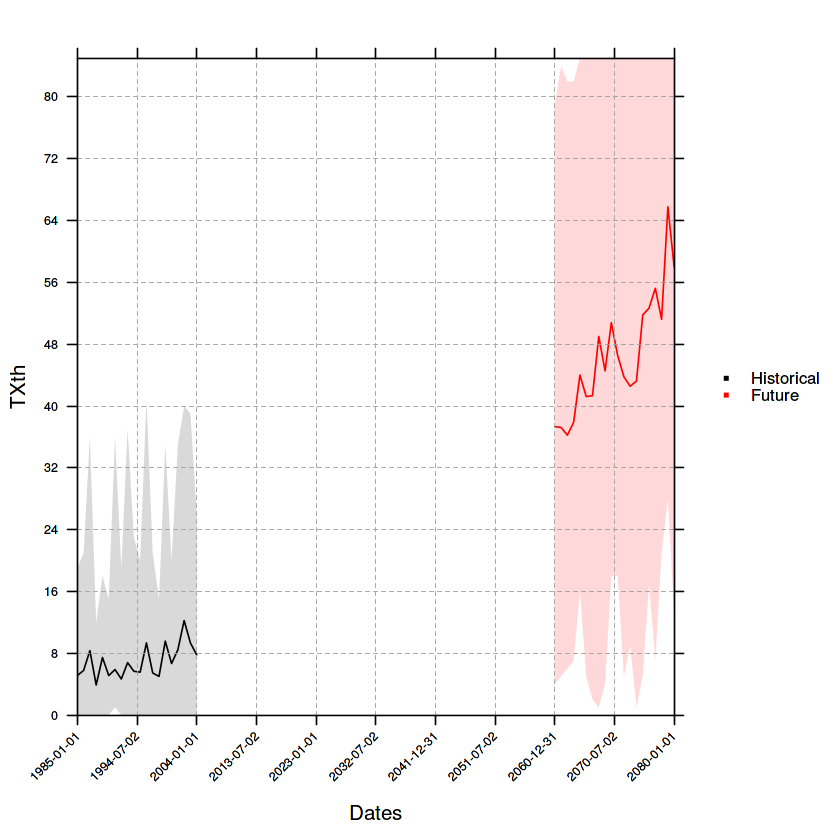

In [26]:
# Here we use `temporalPlot` for a quick overview of the data:
temporalPlot("Historical" = hist.ind, "Future" = fut.ind, 
             lonLim = -3.7, latLim = 40,
             xyplot.custom = list(ylim = c(0, 85), ylab = indcode))

In [48]:
#GRAPHICAL PARAMETERS 
#color palettes
pal <- colorRampPalette(brewer.pal(n = 9, name = "Reds"))(20) # For pr: brewer.pal(n = 10, "BrBG")
pal.sd <- colorRampPalette(brewer.pal(n = 9, name = "Greys"))(20) # For pr: brewer.pal(n = 10, "BrBG")       
setmm <- c(0, 100)      #limits for the deltas in spatialPlot
cuts <- seq(0, 100, 5)  #legend cuts in spatialPlot

[2019-04-30 20:01:50] - Computing climatology...
[2019-04-30 20:01:50] - Done.


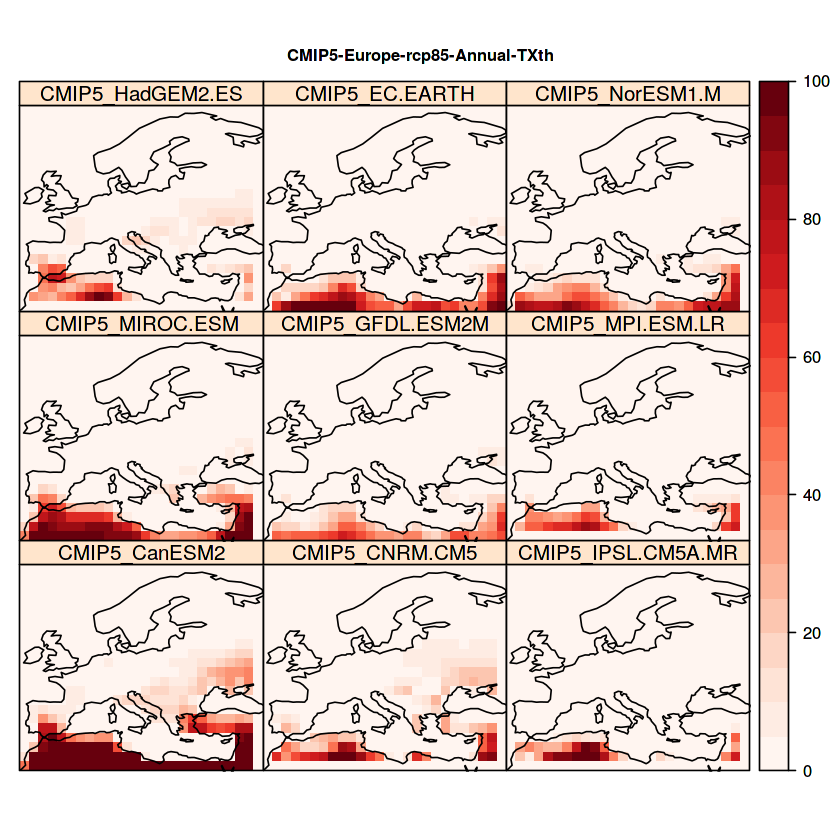

In [49]:
# Map of the historical index
spatialPlot(climatology(hist.ind),
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", gsub(toString(region), pattern = ", ", replacement = "-"), "-", scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

[2019-04-30 20:00:17] - Aggregating members...
[2019-04-30 20:00:17] - Done.
[2019-04-30 20:00:17] - Computing climatology...
[2019-04-30 20:00:17] - Done.


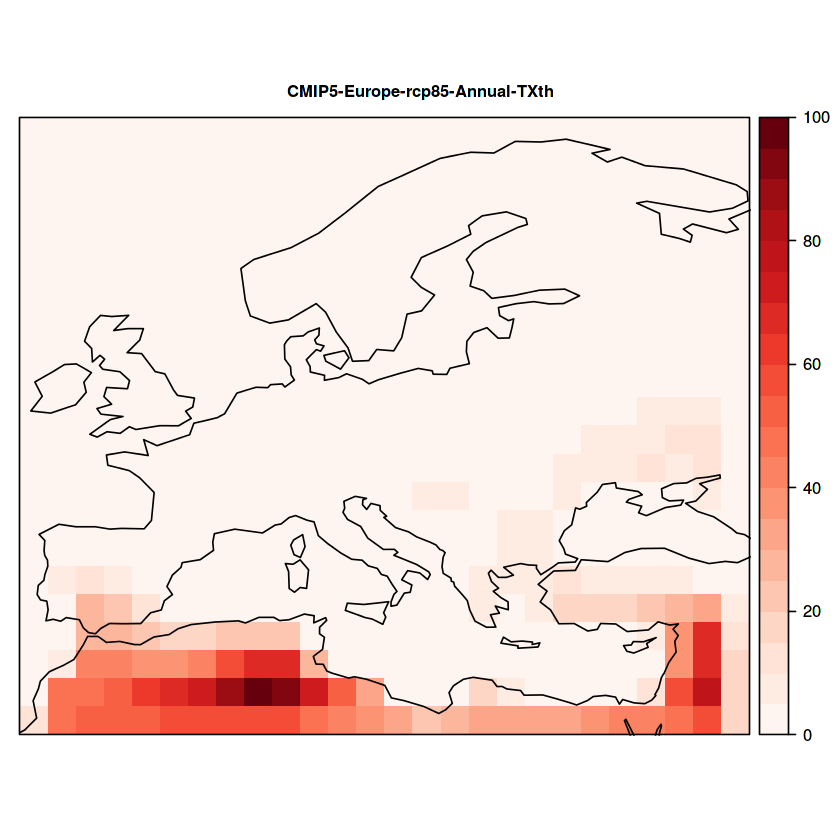

In [44]:
# Map of the historical ensemble mean index
hist.ind.ens <- aggregateGrid(hist.ind, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(climatology(hist.ind.ens),
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", gsub(toString(region), pattern = ", ", replacement = "-"), "-", scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

### 5.2. Days with Tmax above 35º: Climate change signal

In [27]:
delta <- gridArithmetics(climatology(fut.ind), climatology(hist.ind), operator = "-")

[2019-04-30 20:21:23] - Computing climatology...
[2019-04-30 20:21:23] - Done.
[2019-04-30 20:21:23] - Computing climatology...
[2019-04-30 20:21:23] - Done.


In [36]:
#GRAPHICAL PARAMETERS 
#color palettes
pal <- colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(14)
pal.sd <- colorRampPalette(brewer.pal(n = 9, name = "Greys"))(14)       

setmm <- c(-70, 70)  #limits for the deltas in spatialPlot
setmmsd <- c(0, 70)  #limits for the delta deviations
lllim <- c(0, 30)    #limits for the deltas in temporalPlot
cuts <- seq(-70, 70, 10)  #legend cuts in spatialPlot
cutssd <- seq(0, 70, 5)   #legend cuts in spatialPlot for deviation maps

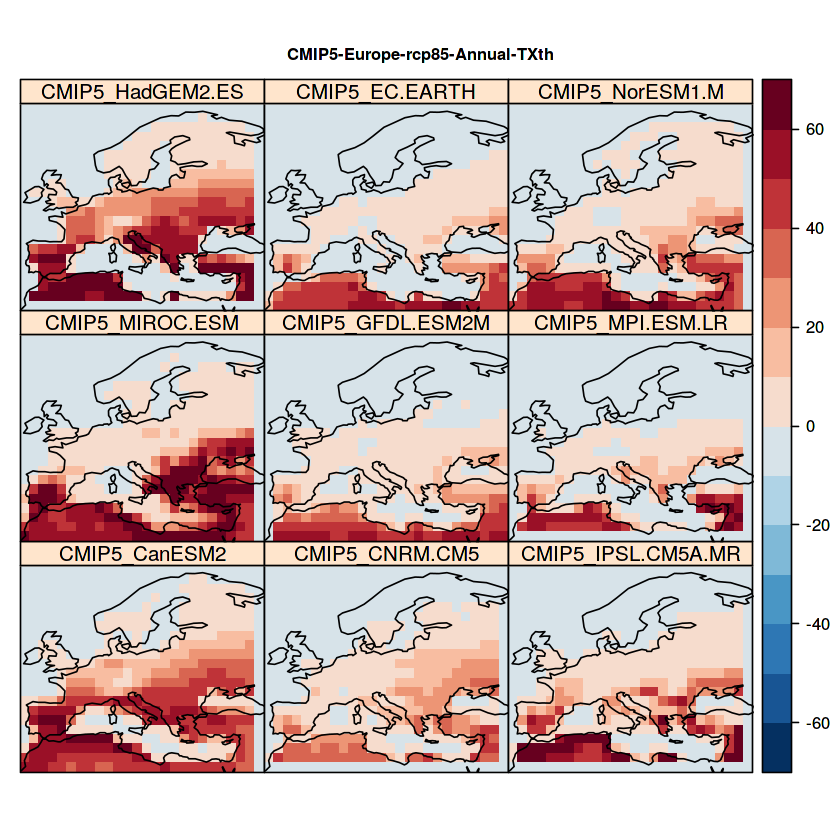

In [52]:
spatialPlot(delta,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                        gsub(toString(region),pattern = ", ", replacement = "-"), "-", 
                        scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

[2019-04-30 20:02:03] - Aggregating members...
[2019-04-30 20:02:03] - Done.


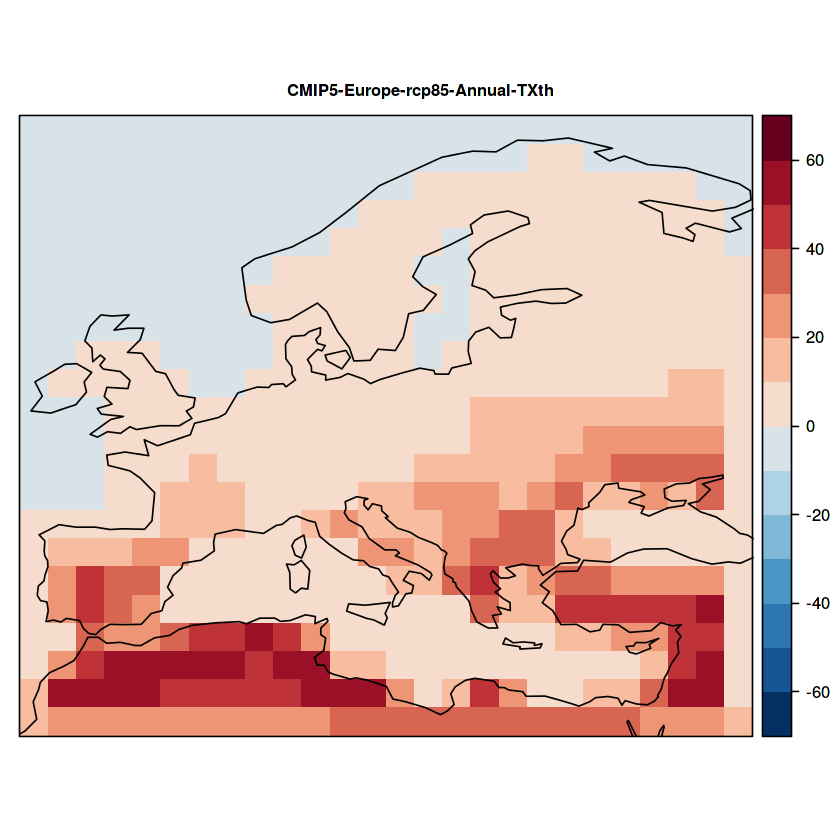

In [51]:
# Map of the ensemble mean delta 
delta.ens <- aggregateGrid(delta, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(delta.ens,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                    gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                    scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

[2019-04-26 15:33:03] - Aggregating members...
[2019-04-26 15:33:03] - Done.
[2019-04-26 15:33:03] - Computing climatology...
[2019-04-26 15:33:03] - Done.


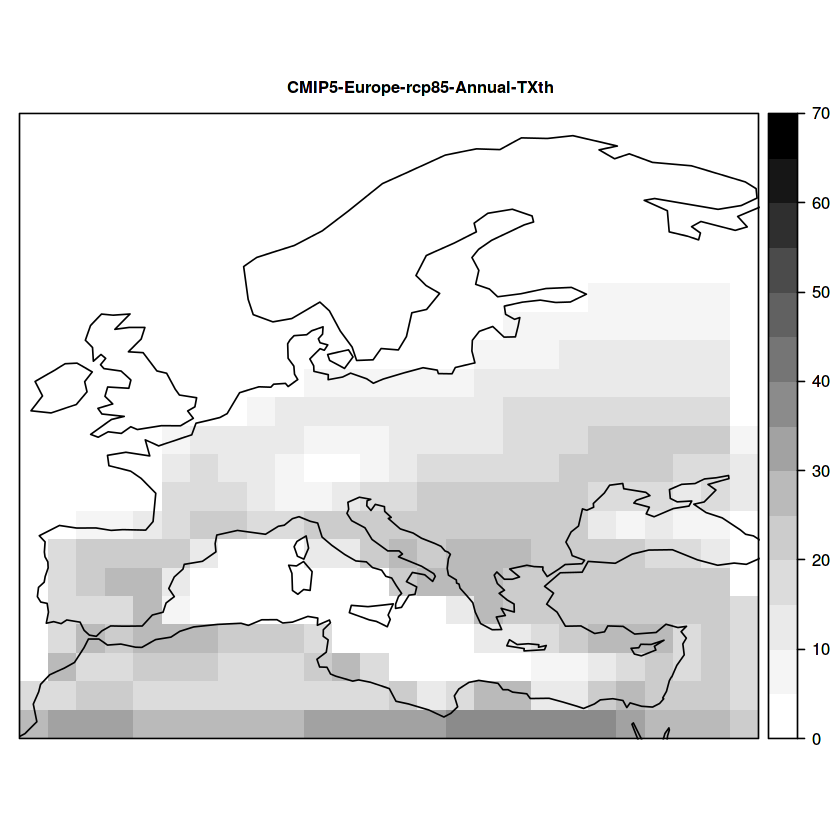

In [62]:
# Map of the ensemble delta spread
delta.sd <- aggregateGrid(delta, aggr.mem = list(FUN = "sd", na.rm = TRUE))
spatialPlot(delta.sd,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                    gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                    scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmmsd[2],
            set.min = setmmsd[1],
            at = cutssd,
            col.regions = pal.sd,
            backdrop.theme = "coastline")

## 6. Bias Correction 



Bias correction is performed by the `biasCorrection` function, from the `downscaleR` package. This function includes a number of standard bias correction methods:

* local (mean/variance) scaling,
* parametric (binomial+gamma) quantile mapping (PQM).
* PQM with generalized Pareto for the extremes (GPQM).
* empirical quantile mapping, with different extrapolation options (EQM).

All methods can be applied separately to each calendar day (or block of days) using a moving window (e.g. `window = c(30, 30)` for a 30-day moving window). The methods PQM, GPQM and EQM have contributed to the VALUE intercomparisson initiative and are described and validated in Gutiérrez et al. 2019 DOI: 10.1002/joc.5462 (see ?biasCorrection or the wiki for more details on this function). In the following example we apply the standard EQM method; note that no moving window is applied in this case to reduce the computation time.


In [32]:
# Historical
hist.bc <- biasCorrection(y = obs2, x = hist, method = "eqm", window = c(30, 30))

[2019-04-30 20:24:28] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2019-04-30 20:24:31] Number of windows considered: 11...
[2019-04-30 20:24:31] Bias-correcting 9 members separately...
[2019-04-30 20:26:20] Done.


In [33]:
# Future
fut.bc <- biasCorrection(y = obs2, x = hist, newdata = fut, method = "eqm", 
                         window = c(30, 30), extrapolation = "constant")

[2019-04-30 20:26:30] Argument precipitation is set as FALSE, please ensure that this matches your data.
[2019-04-30 20:26:32] Number of windows considered: 11...
[2019-04-30 20:26:33] Bias-correcting 9 members separately...
[2019-04-30 20:28:22] Done.


In [34]:
hist.ind.bc <- indexGrid(tx = hist.bc, index.code = indcode, 
                      time.resolution = "year",
                      index.arg.list = list(th = 35))

fut.ind.bc <- indexGrid(tx = fut.bc, index.code = indcode, 
                      time.resolution = "year",
                      index.arg.list = list(th = 35))
delta.bc <- gridArithmetics(climatology(fut.ind.bc), climatology(hist.ind.bc), operator = "-")

[2019-04-30 20:28:29] Calculating TXth ...
[2019-04-30 20:28:31] Done
[2019-04-30 20:28:31] Calculating TXth ...
[2019-04-30 20:28:33] Done
[2019-04-30 20:28:33] - Computing climatology...
[2019-04-30 20:28:33] - Done.
[2019-04-30 20:28:33] - Computing climatology...
[2019-04-30 20:28:33] - Done.


[2019-04-30 20:29:01] - Aggregating members...
[2019-04-30 20:29:01] - Done.


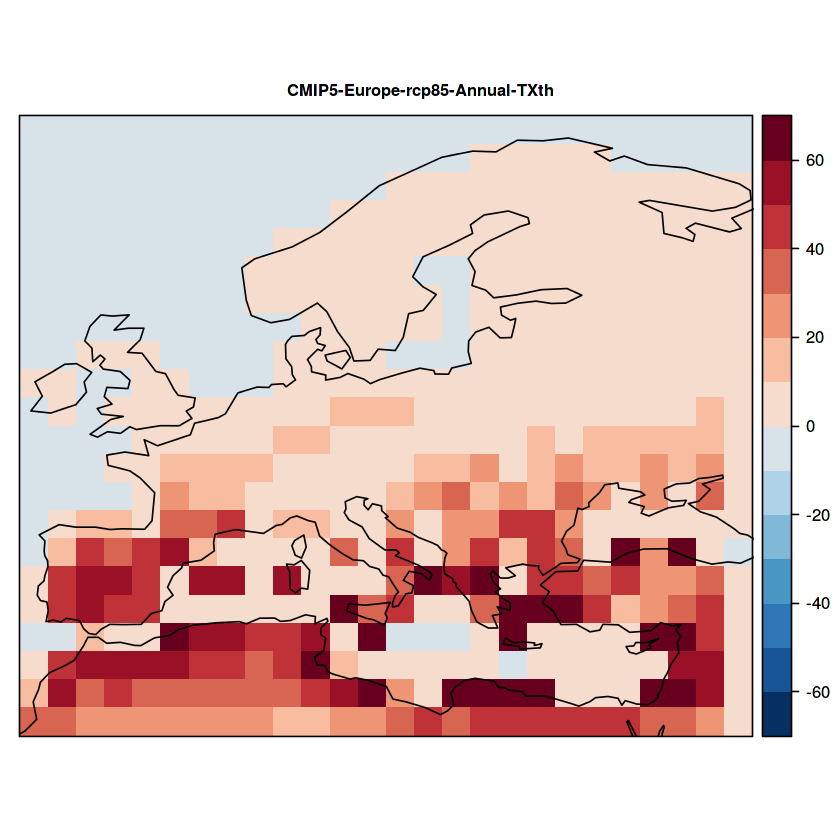

In [37]:
# Map of the ensemble mean bias corrected delta 
delta.ens.bc <- aggregateGrid(delta.bc, aggr.mem = list(FUN = "mean", na.rm = TRUE))
spatialPlot(delta.ens.bc,
            colorkey = TRUE,
            cex = 2.4,
            pch = ".",
            main = list(paste0(source, "-", 
                     gsub(toString(region), pattern = ", ", replacement = "-"), "-", 
                     scenario, "-", season, "-", indcode), cex = 0.8),
            set.max = setmm[2],
            set.min = setmm[1],
            at = cuts,
            col.regions = pal,
            backdrop.theme = "coastline")

## 7. How to export the figures

Figures can be easily exported as *.pdf files by applying function `pdf` before the plotting function and function `dev.off()` after the plotting function. The most important arguments of function `pdf` are `file` (the path of the output pdf file), `width` and `height`. In this example we create object `output.fig` to specify the path of the output pdf file: 

In [70]:
# Specifications to save figures/data to local folders (if required)

fig.height <- 8
fig.width <- 8


In [71]:
output.fig <- "" # write here the output file name

For example, we here use function `paste0` to create the file name:

In [75]:
output.fig <- paste0(fig_dir, source, "_", gsub(toString(region), pattern = ", ", replacement = "-"), "_", scenario, "_", season, "_", paste0(indcode, "35_delta"),"_", gsub(toString(range(period)), pattern = ", ", replacement = "-"),"_timeseries.pdf")
output.fig

[1] "figs/CMIP5_Europe_rcp85_Annual_TXth35_delta_2061-2080_timeseries.pdf"

In [76]:
pdf(file = output.fig, width = 18, height = 5)
temporalPlot(toplot, cols = rep("steelblue3", 48),
             lwd = c(rep(0.8, length(models)), rep(2, 1)),
             lty = c(rep(3, length(models)), rep(1, 1)), 
             xyplot.custom = list(ylim = lllim, ylab = paste(indcode, "delta"), 
                                  main = paste0(source, "-", gsub(toString(region), pattern = ", ", replacement = "-"), "-", scenario, "-", season, "-", indcode, "35")))
dev.off()

pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year
pad applied on the interval: year


png 
  2

Go to the output directory and check that the figure has been created (If needed, download the figure to your local machine). You can add the application of functions `pdf` and `dev.off()` to the rest of the plotting chunks in this or other scripts. 

## NOTE: Use function `help` for a detailed description of the usage of a function, for instance:

In [77]:
help(aggregateGrid)

aggregateGrid {transformeR},R Documentation
grid,a grid or multigrid to be aggregated.
aggr.mem,"Same as aggr.d, but indicating the function for computing the member aggregation."
aggr.d,"Daily aggregation function (for sub-daily data only). A list indicating the name of the aggregation function in first place, and other optional arguments to be passed to the aggregation function. See the examples."
aggr.m,"Same as aggr.d, but indicating the monthly aggregation function."
aggr.y,"Same as aggr.d, but indicating the annual aggregation function."
aggr.lat,"Same as aggr.d, indicating the aggregation function to be applied along latitude."
weight.by.lat,"Logical. Should latitudinal averages be weighted by the cosine of latitude?. Default to TRUE. Ignored if no aggr.lat function is indicated, or a function different from ""mean"" is applied."
aggr.lon,"Same as aggr.lat, but for longitude."
parallel,Logical. Should parallel execution be used?
max.ncores,Integer. Upper bound for user-defined number of cores.
